In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [15]:
# Define transformations for train and test sets
transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 datasets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=2)

In [16]:
model = models.alexnet(pretrained=True)

model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(256 * 6 * 6, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.3),
    nn.Linear(512, 10)
)

model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=9216, out_features=512, bias=True)
  

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [18]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_loss, correct, total = 0.0, 0, 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            loop.set_postfix({'acc': 100 * correct / total, 'loss': train_loss / total})

        train_acc = 100 * correct / total
        train_losses.append(train_loss / total)
        train_accuracies.append(train_acc)

        # Validation loop
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_acc = 100 * val_correct / val_total
        val_losses.append(val_loss / val_total)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}: Train Loss={train_loss/total:.4f}, Train Acc={train_acc:.2f}%, Val Loss={val_loss/val_total:.4f}, Val Acc={val_acc:.2f}%")

        # LR decay after 5 epochs
        if epoch >= 5:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.9

        torch.save(model.state_dict(), f"alexnet_epoch_{epoch+1}.pt")

In [19]:
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10)

Epoch 1: Train Loss=0.6006, Train Acc=79.40%, Val Loss=0.4479, Val Acc=84.58%


Epoch 2: Train Loss=0.3460, Train Acc=88.19%, Val Loss=0.3490, Val Acc=88.02%


Epoch 3: Train Loss=0.2687, Train Acc=90.83%, Val Loss=0.3067, Val Acc=89.60%


Epoch 4: Train Loss=0.2153, Train Acc=92.62%, Val Loss=0.3185, Val Acc=89.17%


Epoch 5: Train Loss=0.1755, Train Acc=94.15%, Val Loss=0.3138, Val Acc=90.15%


Epoch 6: Train Loss=0.1466, Train Acc=94.90%, Val Loss=0.3475, Val Acc=90.18%


Epoch 7: Train Loss=0.1152, Train Acc=96.01%, Val Loss=0.3327, Val Acc=90.87%


Epoch 8: Train Loss=0.0899, Train Acc=96.95%, Val Loss=0.3926, Val Acc=90.95%


Epoch 9: Train Loss=0.0738, Train Acc=97.54%, Val Loss=0.3713, Val Acc=90.87%


Epoch 10: Train Loss=0.0574, Train Acc=98.01%, Val Loss=0.4271, Val Acc=91.10%


In [20]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Print accuracy and classification report
acc = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy: {acc * 100:.2f}%\n")
print("Classification Report:\n", classification_report(y_true, y_pred, digits=4))


Test Accuracy: 91.10%

Classification Report:
               precision    recall  f1-score   support

           0     0.9396    0.8860    0.9120      1000
           1     0.9663    0.9460    0.9560      1000
           2     0.8546    0.9110    0.8819      1000
           3     0.8420    0.8100    0.8257      1000
           4     0.8873    0.9370    0.9115      1000
           5     0.8809    0.8580    0.8693      1000
           6     0.9503    0.9370    0.9436      1000
           7     0.9426    0.9190    0.9306      1000
           8     0.8918    0.9730    0.9307      1000
           9     0.9638    0.9330    0.9482      1000

    accuracy                         0.9110     10000
   macro avg     0.9119    0.9110    0.9109     10000
weighted avg     0.9119    0.9110    0.9109     10000



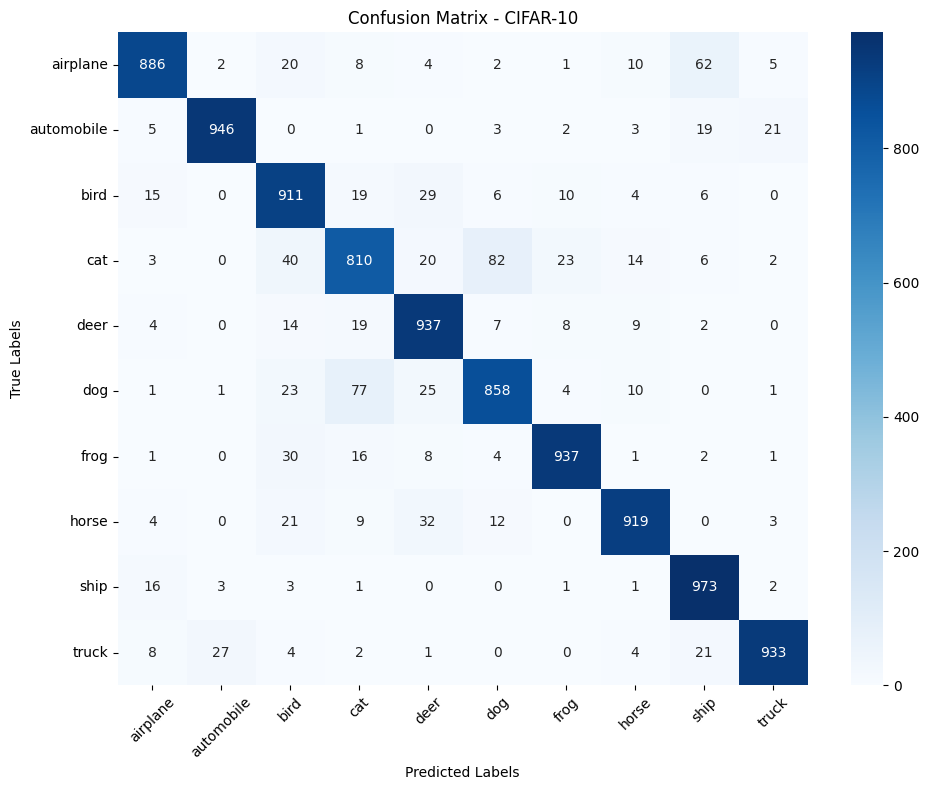

In [21]:
cm = confusion_matrix(y_true, y_pred)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - CIFAR-10")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

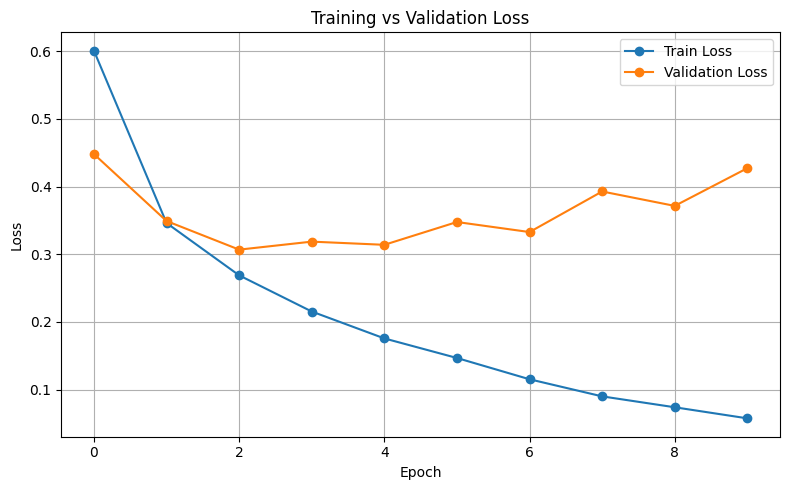

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

<ipython-input-24-55578545513a>:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', 10)


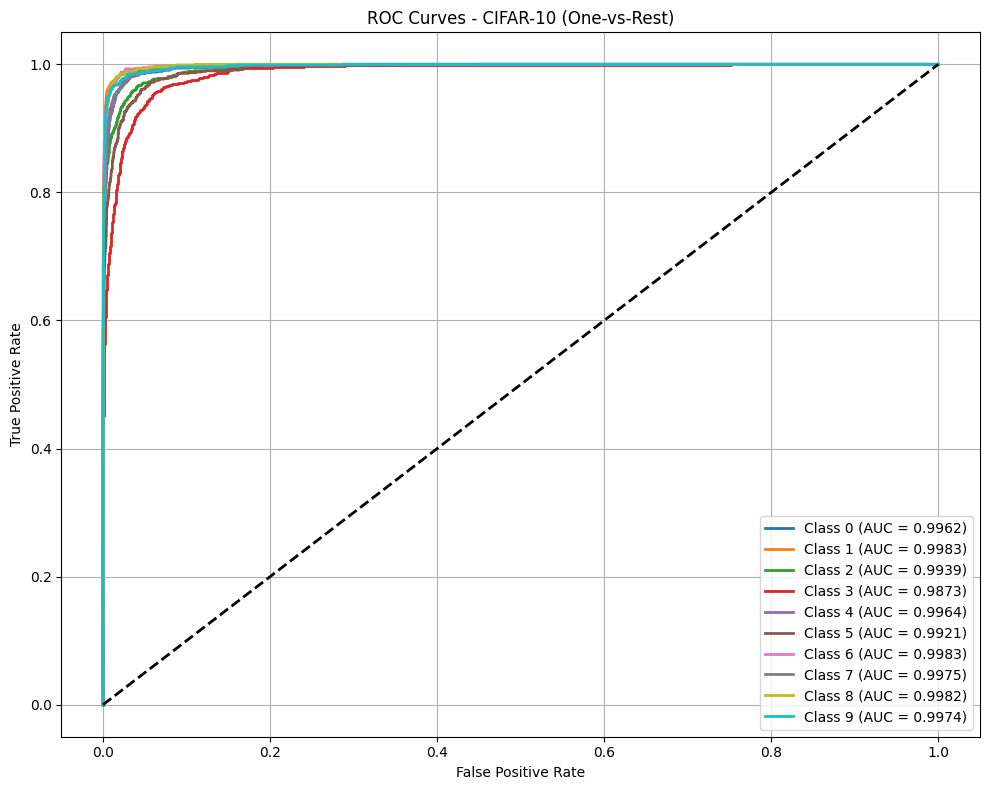

Average AUC: 0.9956


In [24]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize true labels
y_true_bin = label_binarize(y_true, classes=list(range(10)))

# Make predictions and collect softmax probabilities
y_score = []

model.eval()
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)  # get class probabilities
        y_score.extend(probs.cpu().numpy())

y_score = np.array(y_score)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10', 10)
for i in range(10):
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - CIFAR-10 (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print average AUC
mean_auc = np.mean([roc_auc[i] for i in range(10)])
print(f"Average AUC: {mean_auc:.4f}")


In [25]:
all_targets = []
all_probs = []
import torch.nn.functional as F
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs = F.softmax(outputs, dim=1)

        all_targets.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

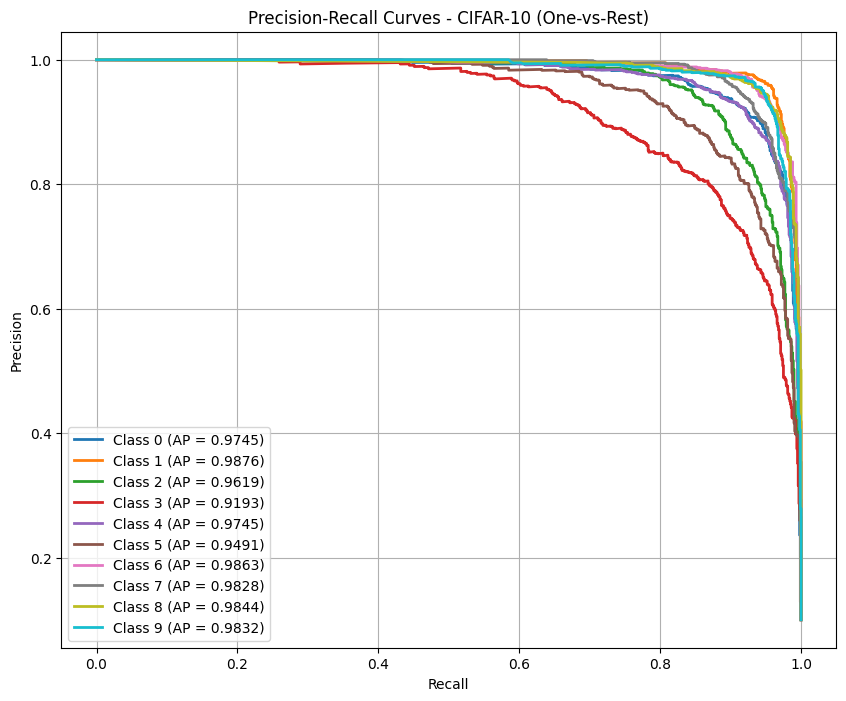

In [26]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize labels for One-vs-Rest
n_classes = 10
y_true_bin = label_binarize(all_targets, classes=list(range(n_classes)))
y_score = np.array(all_probs)

# Plot Precision-Recall curve for each class
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_score[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {i} (AP = {ap:.4f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves - CIFAR-10 (One-vs-Rest)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()